In [4]:
import numpy as np
import matplotlib.cm as cm
import mpl_toolkits.mplot3d.axes3d as axes3d
import scipy.interpolate as interpolate
import tensorflow as tf

from numpy  import array
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential, clone_model
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.utils import np_utils

Using Theano backend.


#### Define Variables

In [5]:
batch_size = 256
vector_size = 784  # 28 * 28 pixels
nbr_classes = 10   # 10 distinct digits
nbr_epochs = 50

np.random.seed(21) 

#### Define Helper Functions

In [6]:
def visualize_1d_loss_function(model1d, a_start, a_end, a_cnt):
    losses = []
    accurs = []
    mu_w, sigma_w = 0, 1
   
    # Retrieve initial weights
    initial_weights = []
    for layer in model1d.layers:
        initial_weights.append(layer.get_weights())
    
    theta_i_weights = []
    for layer in model1d.layers:
        weights_layer = layer.get_weights()
        new_weights = []
        for weight in weights_layer:
            new_weights.append(np.random.normal(mu_w,sigma_w,size=weight.shape))
        theta_i_weights.append(new_weights)
        
    alpha_range = np.linspace(a_start, a_end, a_cnt)
    for alpha in (alpha_range):
        for i, layer in enumerate(model1d.layers):
            new_weights = []
            for j, theta_f_weights in enumerate(initial_weights[i]):
#           θα = (1 − α)θi + αθf 
                new_weights.append((((1-alpha)*(theta_i_weights[i][j])) + (alpha)*theta_f_weights))
            layer.set_weights(new_weights)
        score = model1d.evaluate(X_test, Y_test, verbose=0)
        losses.append(score[0])
        accurs.append(score[1])

    plt_title = 'DNN Model 1D Loss Function Visualization \nAlpha Values = Linespace: ' + str(a_start) + ',' + str(a_end) + ',' + str(a_cnt)
    plt.figure()
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(alpha_range, losses, 'r-');
    ax1.set_xlabel('Alpha')
    ax1.set_ylabel('Alpha generated Loss', color='r')
    ax1.tick_params('y', colors='r')
    ax2 = ax1.twinx()
    ax2.plot(alpha_range, accurs, 'g-');
    ax2.set_ylabel('Test Accuracy', color='g')
    ax2.tick_params('y', colors='g')
    plt.title(plt_title)
    plt.show();
    
    
def visualize_2d_loss_function(model2d, start, end, size):
    losses = []
    accurs = []
    loss_2d = []
    loss_2d_start = start
    loss_2d_end = end
    loss_2d_size = size
    mu_w, sigma_w = 0, 1
    
    # Retrieve initial weights
    initial_weights = []
    for layer in model2d.layers:
        initial_weights.append(layer.get_weights())

    # αδ
    alpha_vals = np.linspace(loss_2d_start,loss_2d_end,loss_2d_size)
    sigma_weights = []
    for layer in model2d.layers:
        weights_layer = layer.get_weights()
        new_weights = []
        for weight in weights_layer:
            new_weights.append(np.random.normal(mu_w, sigma_w, size = weight.shape))
        sigma_weights.append(new_weights)

# βη
    beta_vals = np.linspace(loss_2d_start,loss_2d_end,loss_2d_size)
    nu_weights = []
    for layer in model2d.layers:
        weights_layer = layer.get_weights()
        new_weights = []
        for weight in weights_layer:
            new_weights.append(np.random.normal(mu_w, sigma_w, size = weight.shape))
        nu_weights.append(new_weights)

# iterate loss function
    loss_2d = np.zeros([loss_2d_size,loss_2d_size])
    for a in range(loss_2d_size):
        for b in range(loss_2d_size):
            ax = alpha_vals[a]
            bx = beta_vals[b]
            for i, layer in enumerate(model2d.layers):
                new_weights = []
                for j, theta_f_weights in enumerate(initial_weights[i]):
#               θ′ = θ∗ + αδ + βη
                     new_weights.append(theta_f_weights + (ax*nu_weights[i][j]) + (bx*sigma_weights[i][j]))
                layer.set_weights(new_weights)
            score = model2d.evaluate(X_test, Y_test, verbose=0)
            losses.append(score[0])
            loss_2d[a, b] =  score[0]
 
    plt_title = 'DNN Model 2D Loss Function Visualization \nAlpha,Beta Values: ' + str(start) + ',' + str(end) + ',' + str(size)
    plt.figure(figsize=(14,6))
    levels = np.arange(.5,2,20)
    norm = cm.colors.Normalize(vmax=abs(loss_2d).max(), vmin=-abs(loss_2d).max())
    cmap = cm.PRGn
    loss_2d_plot = plt.contour(alpha_vals, beta_vals, loss_2d, norm=norm,
                     linestyles=('-',),linewidths=(2,))
    plt.clabel(loss_2d_plot, fontsize=12, inline=1)
    plt.title(plt_title)
    plt.ylabel('Beta')

    plt.show();

#### Load MNIST Data; create test and train datasets

In [7]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 
X_train = X_train.reshape(60000, vector_size)
X_test = X_test.reshape(10000, vector_size)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
 
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nbr_classes)
Y_test = np_utils.to_categorical(y_test, nbr_classes)

60000 train samples
10000 test samples


#### Define Simple DNN - 2 Hidden Layers of 100 and 30 neurons; relu and softmax activation; Adam optimization 

In [11]:
layers2_model = Sequential()
layers2_model.add(Dense(100, input_shape=(784,), activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))
layers2_model.add(Dense(30, activation='relu'))


layers2_model.add(Dense(nbr_classes))
layers2_model.add(Activation('softmax'))

layers2_model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

layers2_model.summary()

layers2_model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=nbr_epochs,
          verbose=0,
          validation_data=(X_test, Y_test))

score = layers2_model.evaluate(X_test, Y_test, verbose=0)
layers2_clone = clone_model(layers2_model.model)
layers2_clone.set_weights(layers2_model.get_weights())

print('**********************************************************')
print('*** DNN 2 Hidden Layer Model Test loss:', score[0])
print('*** DNN 2 Hidden Model Test accuracy:', score[1])
print('**********************************************************')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_7 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_8 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_12 (Dense)             (None, 30)                930       
__________

#### Visualize 1D Loss Function

One simple and lightweight method to plot loss function is to choose two sets of parameters θi and θf , and plot the values of the loss function L(θ) along the line connecting these two sets. We can parameterize this line by choosing a scalar parameter α and defining the weighted average θα = (1 − α)θi + αθf , and compute the function f(θ) = L(θα). Here we choose θi as the randomly assigned initial weights and θf the final well-trained model weights in Part (1) above (global minimum, hopefully).

<Figure size 432x288 with 0 Axes>

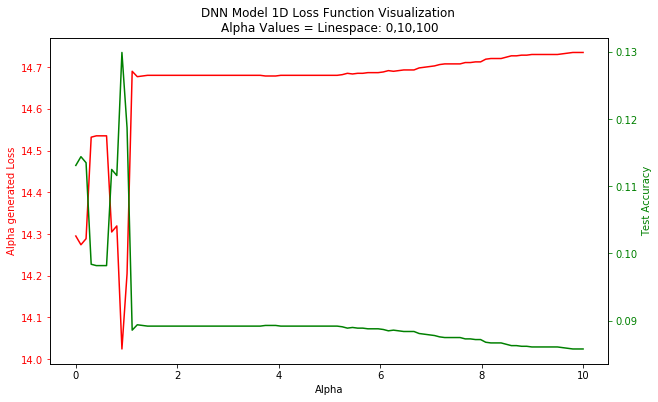

In [14]:
alpha_start = 0
alpha_end = 10
alpha_samples = 100
visualize_1d_loss_function(layers2_model, alpha_start, alpha_end, alpha_samples)

#### 2D Loss Visualization

Given the well trained model θ∗ and global minimum L(θ∗) 
obtained before, generate two random vectors δ and η that have the same length of θ 
and with proper normalization. Calculate θ′ = θ∗ + αδ + βη, and 
then evaluate the loss function L(θ′) and display it in (α,β)-space around its origin, 
which corresponds to the global minimum.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_7 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_8 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_9 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_12 (Dense)             (None, 30)                930       
__________

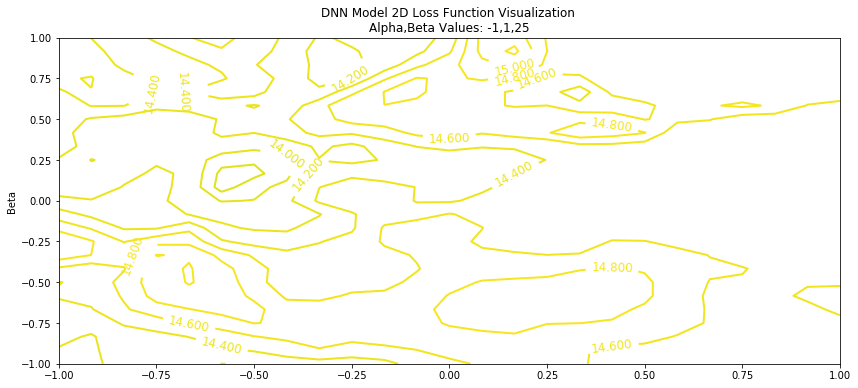

In [15]:
layers2_clone.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
layers2_clone.summary()
loss_start = -1
loss_end = 1
loss_samples = 25
visualize_2d_loss_function(layers2_clone, loss_start, loss_end, loss_samples)